In [7]:
import zipfile
import numpy as np
import pandas as pd
import tensorflow as tf
import pandas
from keras.models import Model
from keras.layers import Dense, Flatten, Input, Activation, Dropout,Rescaling, Conv2D, MaxPooling2D
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import RMSprop
import tensorflow.keras.backend as K

In [8]:
# Read the zip file and extract it to the current directory
zip_file = zipfile.ZipFile('archive.zip')
zip_file.extractall()

In [ ]:
# Delete useless columns
summary = pd.read_csv('Summary.csv')
del summary['Unnamed: 5']
del summary['Unnamed: 6']
# Count the number of calligraphers to be classified
num_classes = len(summary['Label'].unique().tolist())
print(summary)

   Label Calligrapher Name  Total  Training set size  Testing set size
0    wxz               王羲之   6741               5393              1348
1    yzq               颜真卿   6756               5405              1351
2    lgq               柳公权   6763               5410              1353
3    sgt               孙过庭   6251               5001              1250
4    smh               沙孟海   1267               1014               253
5     mf                米芾   6763               5410              1353
6    htj               黄庭坚   6714               5371              1343
7    oyx               欧阳询   3510               2808               702
8    zmf               赵孟頫   2012               1610               402
9    csl               褚遂良   1075                860               215
10   wzm               文征明   4526               3621               905
11   lqs               梁秋生   6757               5406              1351
12   yyr               于右任   6763               5410              1353
13    

In [ ]:
# Process the data and make the data work with keras
data_dir = 'data/data'
batch_size = 512
train = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir + "/train",
    image_size=(64,64),
    seed=1337,
    batch_size=batch_size,
)
test = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir + "/test",
    image_size=(64,64),
    seed=1337,
    batch_size=batch_size,
)

Found 84022 files belonging to 20 classes.
Found 21007 files belonging to 20 classes.


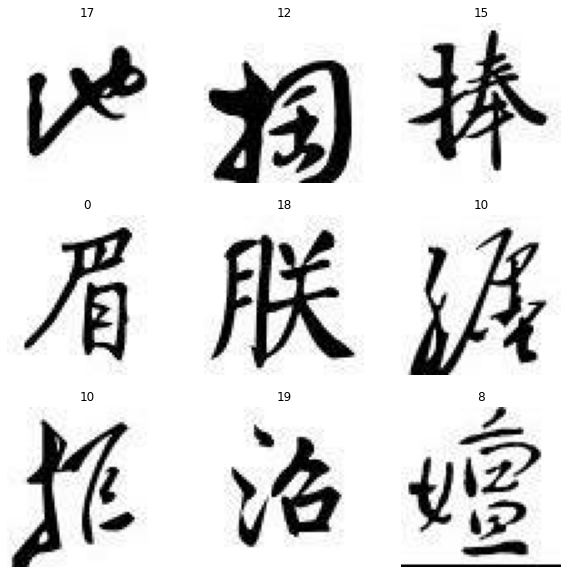

In [ ]:
# Print some data
plt.figure(figsize=(10, 10))
for images, labels in train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [ ]:
# Normalization Function
normalization_layer = Rescaling(1./255)
train = train.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(train))

In [ ]:
# Multilayer perceptron
def MLP():
    inputs = Input(name='inputs', shape=[64, 64, 3])
    layer = Flatten()(inputs)
    layer = Dense(128, input_dim=3 * 64 * 64, activation='relu')(layer)
    layer = Dense(256, activation='relu')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(num_classes, activation="softmax")(layer)
    model = Model(inputs=inputs, outputs=layer)
    return model

In [ ]:
# Calculate recall
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

# Calculate precision
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

# Calculate f1-score
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [ ]:
# Training the MLP model
mlp = MLP()
mlp.summary()
mlp.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=RMSprop(lr=2e-4),
            metrics=['acc', f1_m, precision_m, recall_m])
history_mlp = mlp.fit(train, validation_data=test, batch_size=batch_size, epochs=15)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 64, 64, 3)]       0         
                                                                 
 flatten (Flatten)           (None, 12288)             0         
                                                                 
 dense (Dense)               (None, 128)               1572992   
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 20)                5140  

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


165/165 [==============================] - 47s 273ms/step - loss: 2.9138 - acc: 0.1241 - f1_m: 14.8930 - precision_m: 28581457920.0000 - recall_m: 7.4801 - val_loss: 115.4392 - val_acc: 0.3056 - val_f1_m: 1.0478 - val_precision_m: 1.0384 - val_recall_m: 1.0573
Epoch 2/15
165/165 [==============================] - 50s 295ms/step - loss: 2.3551 - acc: 0.2708 - f1_m: 11.2057 - precision_m: 205272832.0000 - recall_m: 5.9833 - val_loss: 164.4535 - val_acc: 0.3665 - val_f1_m: 1.0107 - val_precision_m: 1.0014 - val_recall_m: 1.0202
Epoch 3/15
165/165 [==============================] - 52s 310ms/step - loss: 2.0531 - acc: 0.3570 - f1_m: 8.4848 - precision_m: 27.1075 - recall_m: 5.0591 - val_loss: 214.2241 - val_acc: 0.3651 - val_f1_m: 1.0032 - val_precision_m: 0.9940 - val_recall_m: 1.0127
Epoch 4/15
165/165 [==============================] - 47s 276ms/step - loss: 1.8854 - acc: 0.4084 - f1_m: 7.1559 - precision_m: 16.7652 - recall_m: 4.5628 - val_loss: 165.2423 - val_acc: 0.4736 - val_f1_m: 1

In [ ]:
# CNN
def CNN():
    inputs = Input(name='inputs', shape=(64, 64, 3))
    layer = Conv2D(16, (3, 3), padding="same", activation="relu")(inputs)
    layer = MaxPooling2D(strides=2)(layer)
    layer = Conv2D(32, (3, 3), padding="same", activation="relu")(layer)
    layer = MaxPooling2D(strides=2)(layer)
    layer = Conv2D(64, (3, 3), padding="same", activation="relu")(layer)
    layer = MaxPooling2D(strides=2)(layer)
    layer = Flatten()(layer)
    layer = Dense(512, input_dim=3 * 256 * 256, activation='relu')(layer)
    layer = Dense(1024, activation='relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(num_classes, activation="softmax")(layer)
    model = Model(inputs=inputs, outputs=layer)
    return model

In [ ]:
# Training the CNN model
cnn = CNN()
cnn.summary()
cnn.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=RMSprop(lr=2e-4),
            metrics=['acc', f1_m, precision_m, recall_m])
history_cnn = cnn.fit(train, validation_data=test, batch_size=batch_size, epochs=15)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        1849

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


165/165 [==============================] - 374s 2s/step - loss: 1.9731 - acc: 0.4010 - f1_m: 9.4126 - precision_m: 8578060288.0000 - recall_m: 5.3360 - val_loss: 152.5426 - val_acc: 0.5581 - val_f1_m: 0.9978 - val_precision_m: 0.9879 - val_recall_m: 1.0080
Epoch 2/15
165/165 [==============================] - 373s 2s/step - loss: 1.1202 - acc: 0.6459 - f1_m: 3.8781 - precision_m: 5.1518 - recall_m: 3.1235 - val_loss: 183.8389 - val_acc: 0.6108 - val_f1_m: 0.9937 - val_precision_m: 0.9838 - val_recall_m: 1.0039
Epoch 3/15
165/165 [==============================] - 373s 2s/step - loss: 0.8588 - acc: 0.7217 - f1_m: 2.9623 - precision_m: 3.4812 - recall_m: 2.5806 - val_loss: 98.3406 - val_acc: 0.7463 - val_f1_m: 0.9952 - val_precision_m: 0.9860 - val_recall_m: 1.0046
Epoch 4/15
165/165 [==============================] - 372s 2s/step - loss: 0.6934 - acc: 0.7757 - f1_m: 2.4928 - precision_m: 2.7806 - recall_m: 2.2602 - val_loss: 183.0903 - val_acc: 0.6514 - val_f1_m: 0.9952 - val_precision_

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics._classification import _check_targets
# Draw the MLP & CNN train loss iterative graph with epoch
def plot_loss(loss=[], label=[]):
    for loss_list, name in zip(loss, label):
        plt.plot(loss_list, label=name + ' train loss', ls='-')
    plt.legend()
    plt.show()

# Draw the train & test dataset, acc iterative graph with epoch
def plot_acc(acc=[], label=[]):
    for loss_list, name in zip(acc, label):
        plt.plot(loss_list[0], label=name + ' train acc', ls='-')
        plt.plot(loss_list[1], label=name + ' test acc', ls='-.')
    plt.legend()
    plt.show()

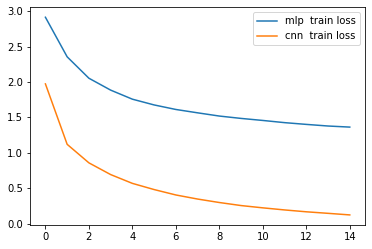

In [ ]:
plot_loss([history_mlp.history['loss'],history_cnn.history['loss']],['mlp ','cnn '])

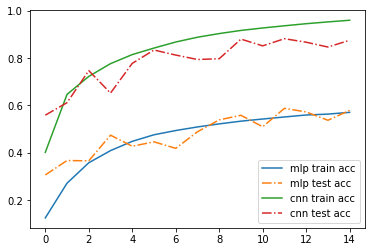

In [ ]:
plot_acc([[history_mlp.history['acc'],history_mlp.history['val_acc']],[history_cnn.history['acc'],history_cnn.history['val_acc']]],['mlp','cnn'])